<div style="background-color:#f0f8ff; padding:10px; border:1px solid #ccc; border-radius:5px;">

# Project Overview

</div>

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import lightgbm as lgb
import shap
import warnings

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, confusion_matrix

warnings.filterwarnings("ignore", category=UserWarning, module="shap")
warnings.filterwarnings("ignore", category=FutureWarning, message=".*observed=False.*")

from tqdm import TqdmWarning
warnings.filterwarnings("ignore", category=TqdmWarning)

<div style="background-color:#f0f8ff; padding:10px; border:1px solid #ccc; border-radius:5px;">

# Import Data

</div>

In [20]:
# Main training data (client-level features and target data)
df_application_train = pd.read_csv("../data/application_train.csv")

# Credit bureau records, their credit history
df_bureau = pd.read_csv("../data/bureau.csv")

# Credit card balance history
df_credit_card_balance = pd.read_csv("../data/credit_card_balance.csv")

<div style="background-color:#f0f8ff; padding:10px; border:1px solid #ccc; border-radius:5px;">

# Data Overview

</div>

In [21]:
df_application_train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [22]:
df_bureau.head()

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.0,NaN,NaN,0.0,Credit card,-16,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,NaN,0.0,Consumer credit,-21,NaN


In [23]:
df_credit_card_balance.head()

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,...,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,2562384,378907,-6,56.970,135000,0.0,877.5,0.0,877.5,1700.325,...,0.000,0.000,0.0,1,0.0,1.0,35.0,Active,0,0
1,2582071,363914,-1,63975.555,45000,2250.0,2250.0,0.0,0.0,2250.000,...,64875.555,64875.555,1.0,1,0.0,0.0,69.0,Active,0,0
2,1740877,371185,-7,31815.225,450000,0.0,0.0,0.0,0.0,2250.000,...,31460.085,31460.085,0.0,0,0.0,0.0,30.0,Active,0,0
3,1389973,337855,-4,236572.110,225000,2250.0,2250.0,0.0,0.0,11795.760,...,233048.970,233048.970,1.0,1,0.0,0.0,10.0,Active,0,0
4,1891521,126868,-1,453919.455,450000,0.0,11547.0,0.0,11547.0,22924.890,...,453919.455,453919.455,0.0,1,0.0,1.0,101.0,Active,0,0


<div style="background-color:#f0f8ff; padding:10px; border:1px solid #ccc; border-radius:5px;">

# EDA

</div>

In [24]:
target_counts = df_application_train['TARGET'].value_counts()
target_ratio = df_application_train['TARGET'].value_counts(normalize=True) * 100

target_summary = pd.DataFrame({
    'Count': target_counts,
    'Percent (%)': target_ratio.round(2)
})

print(target_summary)

         Count  Percent (%)
TARGET                     
0       282686        91.93
1        24825         8.07


<div style="background-color:#e6f4ea; padding:10px; border:1px solid #ccc; border-radius:5px;">
The dataset is highly imbalanced — most clients(91.93%) successfully repay their loans.
<br>
It tells us the label is highly imbalanced.
<br>    
<br>    
Although SMOTE could be considered, it is not applied in this notebook.
<br>
I used LightGBM, which usually does not require SMOTE, and sometimes SMOTE might cause overfitting.
</div>

In [25]:
credit_active_counts = df_bureau['CREDIT_ACTIVE'].value_counts(dropna=False)
credit_active_ratio = df_bureau['CREDIT_ACTIVE'].value_counts(normalize=True, dropna=False) * 100

credit_active_summary = pd.DataFrame({
    'Count': credit_active_counts,
    'Percent (%)': credit_active_ratio.round(2)
})

print(credit_active_summary)


                 Count  Percent (%)
CREDIT_ACTIVE                      
Closed         1079273        62.88
Active          630607        36.74
Sold              6527         0.38
Bad debt            21         0.00


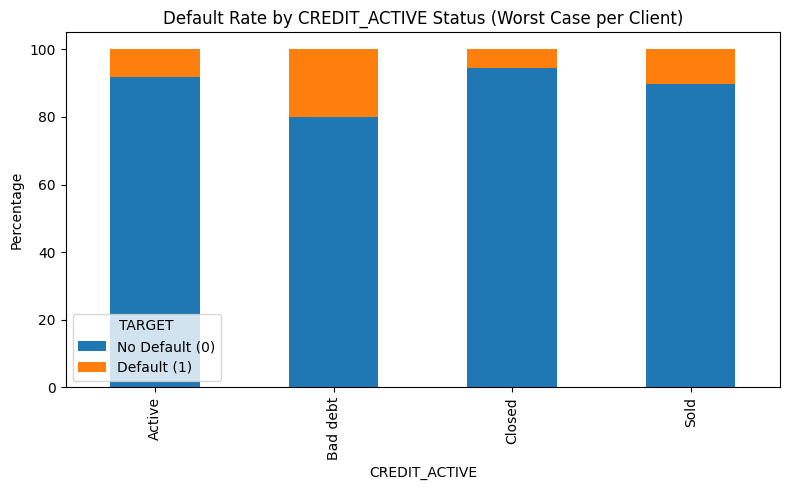

In [26]:
status_priority = {
    'Bad debt': 0,
    'Sold': 1,
    'Active': 2,
    'Closed': 3
}

df_bureau['STATUS_PRIORITY'] = df_bureau['CREDIT_ACTIVE'].map(status_priority)
worst_status = df_bureau.loc[df_bureau.groupby('SK_ID_CURR')['STATUS_PRIORITY'].idxmin()][['SK_ID_CURR', 'CREDIT_ACTIVE']]
merged = df_application_train[['SK_ID_CURR', 'TARGET']].merge(worst_status, on='SK_ID_CURR', how='left')
summary = merged.groupby(['CREDIT_ACTIVE', 'TARGET']).size().unstack(fill_value=0)
summary_percent = summary.div(summary.sum(axis=1), axis=0) * 100

summary_percent.plot(kind='bar', stacked=True, figsize=(8, 5))
plt.title("Default Rate by CREDIT_ACTIVE Status (Worst Case per Client)")
plt.ylabel("Percentage")
plt.xlabel("CREDIT_ACTIVE")
plt.legend(title='TARGET', labels=['No Default (0)', 'Default (1)'])
plt.tight_layout()
plt.show()

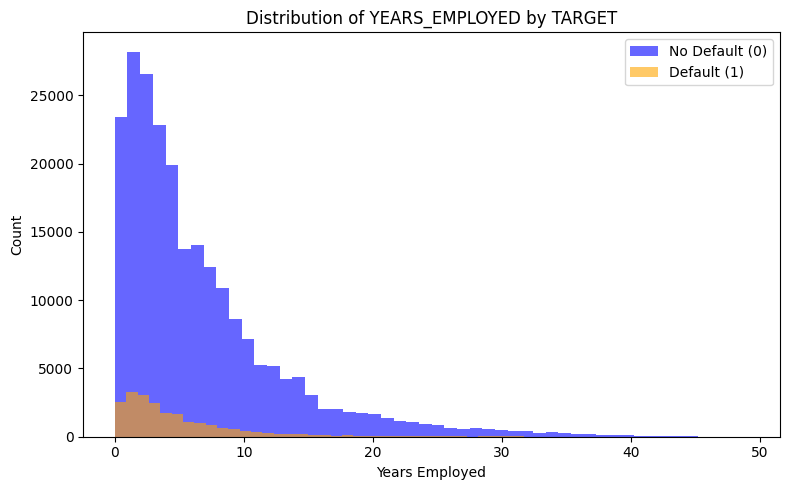

In [27]:
plt.figure(figsize=(8, 5))

# Remove placeholder value for unemployed clients (365243)
filtered = df_application_train[df_application_train['DAYS_EMPLOYED'] != 365243].copy()

# Convert to years (absolute value, rounded to 1 decimal place)
filtered['YEARS_EMPLOYED'] = (filtered['DAYS_EMPLOYED'].abs() / 365).round(1)

# Plot histogram
filtered[filtered['TARGET'] == 0]['YEARS_EMPLOYED'].plot(
    kind='hist', bins=50, alpha=0.6, label='No Default (0)', color='blue'
)

filtered[filtered['TARGET'] == 1]['YEARS_EMPLOYED'].plot(
    kind='hist', bins=50, alpha=0.6, label='Default (1)', color='orange'
)

plt.title('Distribution of YEARS_EMPLOYED by TARGET')
plt.xlabel('Years Employed')
plt.ylabel('Count')
plt.legend()
plt.tight_layout()
plt.show()


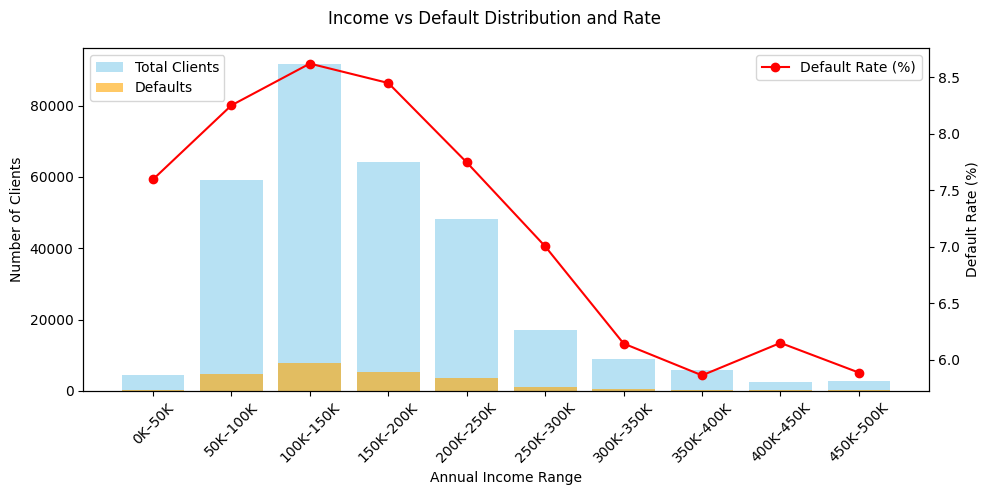

In [28]:
max_income = 500000
filtered = df_application_train[df_application_train['AMT_INCOME_TOTAL'] < max_income].copy()

bins = np.arange(0, max_income + 50000, 50000)
labels = [f'{int(b/1000)}K–{int(bins[i+1]/1000)}K' for i, b in enumerate(bins[:-1])]

filtered['INCOME_BIN'] = pd.cut(filtered['AMT_INCOME_TOTAL'], bins=bins, labels=labels, right=False)

summary = filtered.groupby('INCOME_BIN')['TARGET'].agg(['count', 'sum'])
summary.columns = ['Total', 'Default']
summary['DefaultRate'] = summary['Default'] / summary['Total'] * 100

fig, ax1 = plt.subplots(figsize=(10, 5))

ax1.bar(summary.index, summary['Total'], alpha=0.6, label='Total Clients', color='skyblue')
ax1.bar(summary.index, summary['Default'], alpha=0.6, label='Defaults', color='orange')
ax1.set_ylabel("Number of Clients")
ax1.set_xlabel("Annual Income Range")
ax1.tick_params(axis='x', rotation=45)

ax2 = ax1.twinx()
ax2.plot(summary.index, summary['DefaultRate'], color='red', marker='o', label='Default Rate (%)')
ax2.set_ylabel("Default Rate (%)")

fig.suptitle("Income vs Default Distribution and Rate")
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.tight_layout()
plt.show()

<div style="background-color:#e6f4ea; padding:10px; border:1px solid #ccc; border-radius:5px;">

We explored the relationships between the target variable (default risk) and the following features:

- `CREDIT_ACTIVE`: status of external credit (e.g., active, closed, bad debt)
- `DAYS_EMPLOYED`: length of employment
- `AMT_INCOME_TOTAL`: annual income

In all three cases, the results aligned with common expectations — for example,  
clients with longer employment, higher income, or fully repaid external loans were less likely to default.

Based on these findings, we incorporated these features (and their derived variants) into our model.

</div>

<div style="background-color:#f0f8ff; padding:10px; border:1px solid #ccc; border-radius:5px;">

# Feature Engineering

</div>

In [29]:
# Aggregate credit card features per client
df_credit_features = df_credit_card_balance.groupby("SK_ID_CURR").agg({
    "AMT_PAYMENT_CURRENT": ["sum", "std"],
    "AMT_BALANCE": ["std"],
    "AMT_CREDIT_LIMIT_ACTUAL": ["mean"],
    "CNT_DRAWINGS_ATM_CURRENT": ["sum"],
    "SK_DPD": ["sum"],
    "SK_DPD_DEF": ["sum"],
    "CNT_INSTALMENT_MATURE_CUM": ["sum"],
    "CNT_DRAWINGS_CURRENT": ["sum"],
    "AMT_TOTAL_RECEIVABLE": ["sum"],
    "AMT_INST_MIN_REGULARITY": ["mean"],
    "AMT_DRAWINGS_CURRENT": ["sum", "mean", "std"],
    "AMT_DRAWINGS_POS_CURRENT": ["sum", "mean", "std"]
})

# Flag bad debt accounts
df_bureau['BAD_DEBT_FLAG'] = (df_bureau['CREDIT_ACTIVE'] == 'Bad debt').astype(int)

# Aggregate bureau features per client
df_bureau_features = df_bureau.groupby("SK_ID_CURR").agg({
    "BAD_DEBT_FLAG": "max",
    "DAYS_CREDIT": "max",
    "CREDIT_DAY_OVERDUE": ["max", "mean"],
    "AMT_CREDIT_MAX_OVERDUE": ["max", "sum"],
    "CNT_CREDIT_PROLONG": "max",
    "AMT_CREDIT_SUM": "mean",
    "AMT_CREDIT_SUM_LIMIT": "mean",
    "AMT_CREDIT_SUM_OVERDUE": ["max", "sum"],
    "DAYS_CREDIT_UPDATE": "min",
    "AMT_ANNUITY": "max"
})

# Flatten column names
df_bureau_features.columns = ['_'.join(col).upper() for col in df_bureau_features.columns]
df_bureau_features = df_bureau_features.reset_index()
df_credit_features.columns = ['_'.join(col).upper() if isinstance(col, tuple) else col for col in df_credit_features.columns]
df_credit_features = df_credit_features.reset_index()

# Merge credit and bureau features
df_credit_features = df_credit_features.merge(df_bureau_features, on="SK_ID_CURR", how="outer")


<div style="background-color:#f0f8ff; padding:10px; border:1px solid #ccc; border-radius:5px;">

# Modeling

</div>

In [30]:
# Merge application and credit features
df_application_train = df_application_train.merge(df_credit_features, on="SK_ID_CURR", how="left")

# Feature list
features = [
    'CNT_CHILDREN',
    'AMT_INCOME_TOTAL',
    'EXT_SOURCE_1',
    'EXT_SOURCE_2',
    'EXT_SOURCE_3',
    'DAYS_BIRTH',
    'AMT_CREDIT',
    'DAYS_EMPLOYED',
    'DAYS_REGISTRATION',
    'AMT_ANNUITY',
    
    # from credit_card_balance
    'AMT_PAYMENT_CURRENT_SUM',
    'AMT_PAYMENT_CURRENT_STD',
    'AMT_BALANCE_STD',
    'AMT_CREDIT_LIMIT_ACTUAL_MEAN',
    'CNT_DRAWINGS_ATM_CURRENT_SUM',
    'SK_DPD_SUM',
    'SK_DPD_DEF_SUM',
    'CNT_INSTALMENT_MATURE_CUM_SUM',
    'CNT_DRAWINGS_CURRENT_SUM',
    'AMT_TOTAL_RECEIVABLE_SUM',
    'AMT_INST_MIN_REGULARITY_MEAN',
    'AMT_DRAWINGS_CURRENT_SUM',
    'AMT_DRAWINGS_CURRENT_MEAN',
    'AMT_DRAWINGS_CURRENT_STD',
    'AMT_DRAWINGS_POS_CURRENT_SUM',
    'AMT_DRAWINGS_POS_CURRENT_MEAN',
    'AMT_DRAWINGS_POS_CURRENT_STD',
    
    # from bureau
    'BAD_DEBT_FLAG_MAX',
    'DAYS_CREDIT_MAX',
    'CREDIT_DAY_OVERDUE_MAX',
    'CREDIT_DAY_OVERDUE_MEAN',
    'AMT_CREDIT_MAX_OVERDUE_MAX',
    'AMT_CREDIT_MAX_OVERDUE_SUM',
    'CNT_CREDIT_PROLONG_MAX',
    'AMT_CREDIT_SUM_MEAN',
    'AMT_CREDIT_SUM_LIMIT_MEAN',
    'AMT_CREDIT_SUM_OVERDUE_MAX',
    'AMT_CREDIT_SUM_OVERDUE_SUM',
    'DAYS_CREDIT_UPDATE_MIN',
    'AMT_ANNUITY_MAX'
]

X = df_application_train[features].copy()
y = df_application_train['TARGET']

# Cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=10)
auc_scores = []

for fold, (train_idx, val_idx) in enumerate(cv.split(X, y)):
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    model = lgb.LGBMClassifier(n_estimators=100, random_state=42, is_unbalance=True)
    model.fit(X_train, y_train)

    y_pred = model.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_pred)
    auc_scores.append(auc)

mean_auc = np.mean(auc_scores)
std_auc = np.std(auc_scores)
print(f"\nMean AUC: {mean_auc:.4f}")
print(f"Std AUC:  {std_auc:.4f}")

[LightGBM] [Info] Number of positive: 19860, number of negative: 226148
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010004 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9093
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080729 -> initscore=-2.432482
[LightGBM] [Info] Start training from score -2.432482
[LightGBM] [Info] Number of positive: 19860, number of negative: 226149
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009529 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9089
[LightGBM] [Info] Number of data points in the train set: 246009, number of used features: 40
[LightGBM] [In

<div style="background-color:#f0f8ff; padding:10px; border:1px solid #ccc; border-radius:5px;">

# Evaluate the Model

</div>


Mean AUC: 0.7517


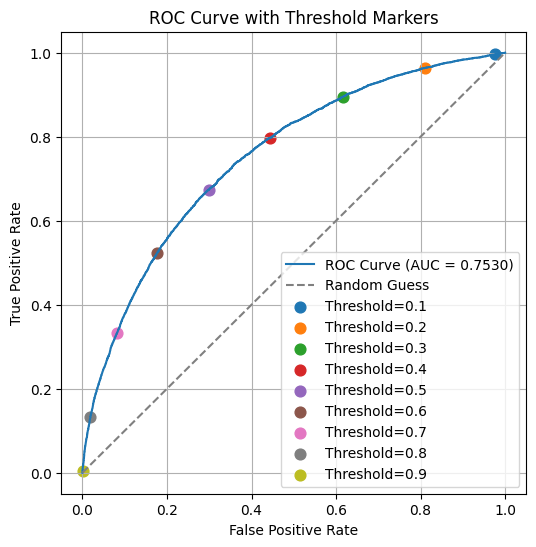

In [31]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

print(f"\nMean AUC: {sum(auc_scores) / len(auc_scores):.4f}")

# Retrieve FPR, TPR, Thresholds
fpr, tpr, thresholds = roc_curve(y_val, y_pred)

plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label="ROC Curve (AUC = {:.4f})".format(roc_auc_score(y_val, y_pred)))
plt.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Random Guess")

for target_thresh in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9 ]:
    idx = (np.abs(thresholds - target_thresh)).argmin()
    plt.scatter(fpr[idx], tpr[idx], label=f"Threshold={target_thresh}", s=60)

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve with Threshold Markers")
plt.legend()
plt.grid(True)
plt.show()

In [32]:
thresholds_to_test = np.arange(0.1, 1.0, 0.1)

confusion_data = []

for thresh in thresholds_to_test:
    y_pred_label = (y_pred >= thresh).astype(int)
    
    tn, fp, fn, tp = confusion_matrix(y_val, y_pred_label).ravel()
    
    confusion_data.append({
        'Threshold': round(thresh, 2),
        'TP': tp,
        'FP': fp,
        'TN': tn,
        'FN': fn,
        'Recall (TPR)': round(tp / (tp + fn + 1e-9), 3),
        'Precision': round(tp / (tp + fp + 1e-9), 3)
    })

df_confusion = pd.DataFrame(confusion_data)
display(df_confusion)

,Threshold,TP,FP,TN,FN,Recall (TPR),Precision
0,0.1,4945,55228,1309,20,0.996,0.082
1,0.2,4787,45874,10663,178,0.964,0.094
2,0.3,4447,34897,21640,518,0.896,0.113
3,0.4,3957,25077,31460,1008,0.797,0.136
4,0.5,3345,16900,39637,1620,0.674,0.165
5,0.6,2592,9951,46586,2373,0.522,0.207
6,0.7,1645,4593,51944,3320,0.331,0.264
7,0.8,653,1048,55489,4312,0.132,0.384
8,0.9,20,16,56521,4945,0.004,0.556


<div style="background-color:#f0f8ff; padding:10px; border:1px solid #ccc; border-radius:5px;">

# SHAP

</div>

In [33]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_val)

shap_df = pd.DataFrame(shap_values, columns=X_val.columns, index=X_val.index)

# display(shap_df.head().T)

shap_summary_df = pd.DataFrame({
    'Mean(|SHAP|)': shap_df.abs().mean(),
}).sort_values(by='Mean(|SHAP|)', ascending=False)

display(shap_summary_df)

,Mean(|SHAP|)
EXT_SOURCE_2,0.365725
EXT_SOURCE_3,0.352380
EXT_SOURCE_1,0.212103
AMT_ANNUITY,0.123077
DAYS_EMPLOYED,0.107075
DAYS_BIRTH,0.101416
AMT_CREDIT,0.079869
DAYS_CREDIT_UPDATE_MIN,0.069155
CNT_DRAWINGS_ATM_CURRENT_SUM,0.047439
AMT_CREDIT_MAX_OVERDUE_MAX,0.047186


<div style="background-color:#f0f8ff; padding:10px; border:1px solid #ccc; border-radius:5px;">

# Feature importances 

</div>

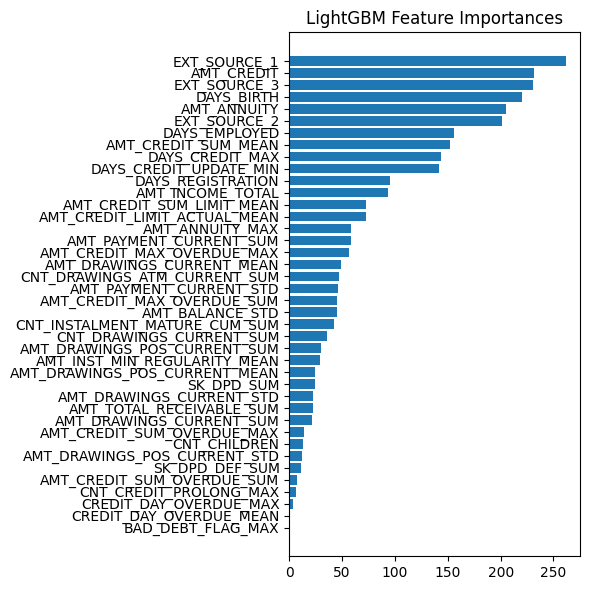

In [34]:
importances = model.feature_importances_
feature_names = X_train.columns

importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
importance_df.sort_values(by='Importance', ascending=False, inplace=True)

plt.figure(figsize=(6, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.gca().invert_yaxis()
plt.title("LightGBM Feature Importances")
plt.tight_layout()
plt.show()